In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
import torch.optim as optim
import numpy as np
from torchvision import transforms
from torchsummary import summary

In [2]:
def fetch_data_from_folder(folder_path: str):
    transform = transforms.Compose([
        transforms.PILToTensor(),
        transforms.Resize((28, 28))
    ])

    x_train = []
    y_train = []

    for name in os.listdir(folder_path):
        y_train.append(0 if name[0].lower() == 'o' else 1)

        path = os.path.join(folder_path, name)
        x_train.append(transform(Image.open(path)))

    return torch.stack(x_train).float(), torch.tensor(y_train)

In [18]:
class XO(Dataset):
    def __init__(self, x, y, transform=None):
        super().__init__()
        self.x = x.float() / 255
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y[i]


x_train, y_train = fetch_data_from_folder('./data/xo/all')
xo_dataset = XO(x_train, y_train)
xo_dataloader = DataLoader(xo_dataset, 128, shuffle=True)

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for ax in axs.flat:
    rand_int = np.random.randint(0, xo_dataset.x.shape[0])
    rand_img = xo_dataset.x[rand_int]

    ax.imshow(rand_img.squeeze(0), cmap='gray')
    ax.axis('off')

In [20]:
def measure_accuracy(_y: torch.Tensor, y: torch.Tensor):
    return (_y.round() == y).sum() / y.shape[0]

In [25]:
model = nn.Sequential(
    nn.Conv2d(1, 10, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),

    nn.Conv2d(10, 20, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),

    nn.Flatten(),

    nn.Linear(500, 256),
    nn.ReLU(),
    
    nn.Linear(256, 1),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
opt = optim.Adam(model.parameters(), lr=0.01)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    factor=0.5,
    patience=2,
    threshold=0.01,
    threshold_mode='rel',
    min_lr=0.0001,
)

In [ ]:
epochs = 30

losses = []
accuracies = []

for epoch in range(epochs):
    avg_trn_loss = 0
    for x, y in xo_dataloader:
        model.train()

        _y = model(x)
        loss = criterion(_y, y.float().unsqueeze(1))
        avg_trn_loss += loss.item()

        accuracy = measure_accuracy(_y, y.unsqueeze(1))

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        accuracies.append(accuracy.item())

    avg_trn_loss /= len(xo_dataloader)
    scheduler.step(avg_trn_loss)

    print(f"Epoch: {epoch}, Mean Loss: {avg_trn_loss}, Accuracy: {accuracies[-1]}, LR: {opt.param_groups[0]['lr']}")

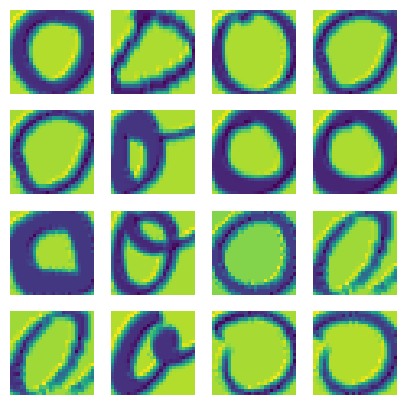

In [69]:
first_layer = model[0]
intermediate_output = [first_layer(x)[3] for x in xo_dataset.x[:16]]

fig, axs = plt.subplots(4,4, figsize=(5,5))

for i, ax in enumerate(axs.flat):
    ax.imshow(intermediate_output[i].detach().numpy())
    ax.axis('off')

In [88]:
model

Sequential(
  (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=500, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=1, bias=True)
  (10): Sigmoid()
)

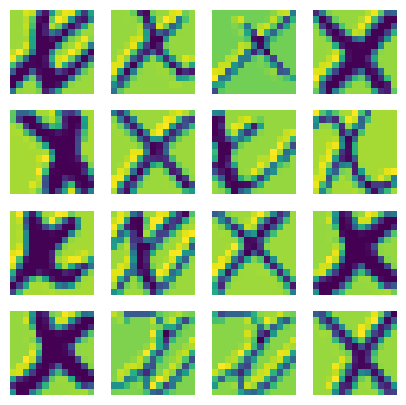

In [110]:
feature_map = 3
sec_layer = model[:2]
intermediate_output = [sec_layer(x)[feature_map] for x in xo_dataset.x[-16:]]

fig, axs = plt.subplots(4,4, figsize=(5,5))

for i, ax in enumerate(axs.flat):
    ax.imshow(intermediate_output[i].detach().numpy())
    ax.axis('off')

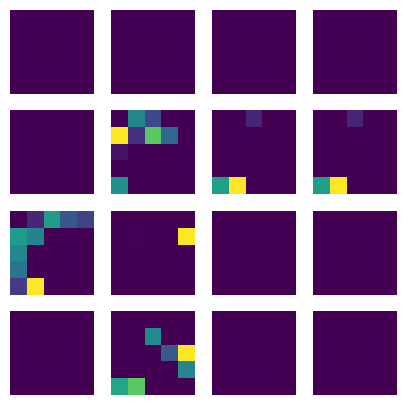

In [106]:
feature_map = 3
sec_layer = model[:6]
intermediate_output = [sec_layer(x)[feature_map] for x in xo_dataset.x[:16]]

fig, axs = plt.subplots(4,4, figsize=(5,5))

for i, ax in enumerate(axs.flat):
    ax.imshow(intermediate_output[i].detach().numpy())
    ax.axis('off')